<a href="https://colab.research.google.com/github/hkayesh/causal-qa/blob/master/Causal_QA_(X_may_cause_Y).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install necessary packages

In [0]:
! pip install transformers

     |████████████████████████████████| 450kB 3.4MB/s 
     |████████████████████████████████| 870kB 10.8MB/s 
     |████████████████████████████████| 1.0MB 20.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=8a11017990cf7347df4cadebae8186a25138687dfc017045bf8629d5dbb92aec
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
! pip install torch

### Import packages

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import re
import nltk
import json
import torch
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google.colab import drive 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, BertForNextSentencePrediction
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from transformers import AlbertForSequenceClassification, AlbertTokenizer

from smart_open import smart_open
from gensim.summarization.textcleaner import split_sentences
from gensim.utils import tokenize, lemmatize
from sklearn.model_selection import train_test_split
from transformers.optimization import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef


TensorFlow 2.x selected.


In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# installing pattern package erquired for gensim's lemmatize() 
!pip install git+git://github.com/pattern3/pattern.git

  Cloning git://github.com/pattern3/pattern.git to /tmp/pip-req-build-kms_i7ex
  Running command git clone -q git://github.com/pattern3/pattern.git /tmp/pip-req-build-kms_i7ex
     |████████████████████████████████| 419kB 3.4MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 194kB 56.0MB/s 
     |████████████████████████████████| 4.1MB 33.4MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for pattern: filename=pattern-2.6-py2.py3-none-any.whl size=18553736 sha256=07794e236d89f530ed9f124940cd67796d84c2fe04072687303c816425307ffb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvys4gc1/wheels/42/86/32/4c2c2365f5f4247ff44ae48bb2290f4fb024b2d2a48bf52a32
  Created wheel for docx: filename=docx-0.2.4-cp36-none-any.whl size=53926 sha256=c72a8387d50dcc969a0375f9af0d4197df4700cee4996ff1418dca975581feab
  Stored

### Mount Google Drive 
(from shamolbit@gmail.com)

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Define Constant Values

In [0]:
RANDOM_SEED = 1
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
NUM_EPOCHS = 2
DATASET_DIR_PATH = 'gdrive/My Drive/Research Data/CausalQA/datasets/'
NEWS_ARTICLES_FILE_PATH = 'gdrive/My Drive/Research Data/CausalQA/causal_pairs_1M_articles.csv'
NOT_CAUSAL_SENTS_FILE_PATH = 'gdrive/My Drive/Research Data/CausalQA/not_causal_pairs_1M_sents.csv'
NUM_CAUSAL_SENTENCES = 100000

#### Set random seeds for reproducibility 

In [0]:
torch.manual_seed(RANDOM_SEED)

### Load Pretraiend model and tokenizer

In [0]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# model = RobertaForSequenceClassification.from_pretrained("roberta-base")
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')


### Load Training Data

In [0]:
# import re
# causal_tuples_file = 'gdrive/My Drive/Research Data/CausalQA/causalTuples/nyt_mar30_combo.argsC'

# simple_wiki_causal_tuples = []
# simple_wiki_not_causal_tuples = []

# with open(causal_tuples_file, 'r') as rows:
#   for index, row in enumerate(rows):
#     splits = row.split('-->', 2)
#     cause_phrase = re.sub('_[A-Z]+', '', splits[0]).strip().lower()
#     effect_phrase = re.sub('_[A-Z]+', '', splits[1]).strip().lower()

#     simple_wiki_causal_tuples.append((cause_phrase, effect_phrase))
#     simple_wiki_not_causal_tuples.append((effect_phrase, cause_phrase)) 

# simple_wiki_causal_df = pd.DataFrame(simple_wiki_causal_tuples[:NUM_CAUSAL_SENTENCES], columns=['sequence_a', 'sequence_b'])
# simple_wiki_causal_df['label'] = 'causal'

# train_dataset_causal_df = simple_wiki_causal_df

# simple_wiki_not_causal_df = pd.DataFrame(simple_wiki_not_causal_tuples[:NUM_CAUSAL_SENTENCES], columns=['sequence_a', 'sequence_b'])
# simple_wiki_not_causal_df['label'] = 'not_causal'

# train_dataset = pd.concat([simple_wiki_causal_df, simple_wiki_not_causal_df])


# print(train_dataset.shape)
# train_dataset.head()

In [0]:
# 1M news articles dataset

causal_pairs_df = pd.read_csv(NEWS_ARTICLES_FILE_PATH, nrows=NUM_CAUSAL_SENTENCES, lineterminator='\n', error_bad_lines=False)
print(causal_pairs_df.shape)

train_dataset_causal_df = causal_pairs_df[['sequence_a', 'sequence_b']]
train_dataset_causal_df['label'] = 'causal'
train_dataset_causal_df.head()
train_dataset_causal_df.shape

not_causal_df = pd.read_csv(NOT_CAUSAL_SENTS_FILE_PATH, nrows=NUM_CAUSAL_SENTENCES, lineterminator='\n', error_bad_lines=False)
train_dataset_not_causal_df = not_causal_df[['sequence_a', 'sequence_b']]
train_dataset_not_causal_df['label'] = 'not_causal'

train_dataset = pd.concat([train_dataset_causal_df, train_dataset_not_causal_df])
print(train_dataset.shape)
train_dataset.head()

(100000, 3)
(200000, 3)


,sequence_a,sequence_b,label
0,its central location and its proximity to the ...,the postal order was chosen,causal
1,you were a basketball fan who was born in the 80s,you were lucky enough to witness the beauty th...,causal
2,words of death spoken over them,individual dreams and visions have been aborted,causal
3,poisonous words,homes and marriages have been destroyed,causal
4,words of envy and jealousy,companies and businesses have fallen,causal


### Show data statistics

Number of pairs, 100000
Vocabulary size, 63471
Longest phrase size, 189
Shortest phrase size, 2
Average phrase size, 9.257625


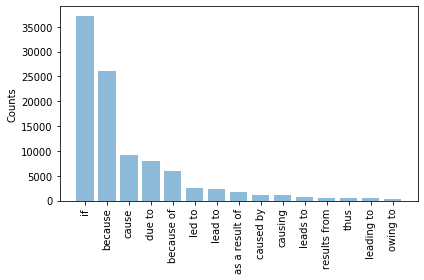

In [0]:
def get_data_stats(df):
  data_stats = []
  data_stats.append(('Number of pairs', df.shape[0]))

  vocabulary = []
  phrase_sizes = []
  for seq_a, seq_b in zip(df['sequence_a'], df['sequence_b']):
    seq_a_tokens = word_tokenize(seq_a)
    seq_b_tokens = word_tokenize(seq_b)

    vocabulary.extend(seq_a_tokens + seq_b_tokens)
    phrase_sizes.extend([len(seq_a_tokens), len(seq_b_tokens)])
  
  vocabulary = list(set(vocabulary))
  data_stats.append(('Vocabulary size', len(vocabulary)))
  data_stats.append(('Longest phrase size', max(phrase_sizes)))
  data_stats.append(('Shortest phrase size', min(phrase_sizes)))
  data_stats.append(('Average phrase size', sum(phrase_sizes)/len(phrase_sizes)))


  return data_stats 

def display_bar_chart(keys, values, out_file = None):
    y_pos = np.arange(len(keys))

    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, keys, rotation=90)
    plt.ylabel('Counts')
    plt.tight_layout()
    if out_file is None:
      plt.show()
    else:
      plt.savefig(out_file)

def get_cue_words_frequencies(causal_pairs_df):
  sentences = causal_pairs_df['sentence']
  causal_cue_words = ['caused by', 'result from', 'resulting from', 'results from', 'results from',
                    'because of', 'because', ', inasmuch as', 'due to', 'in consequence of',
                    'owing to', 'as a result of', 'as a consequence of', 'lead to', 'leads to', 'led to',
                    'leading to', 'give rise to', 'gave rise to', 'given rise to', 'giving rise to', 'induce',
                    'inducing', 'induces', 'induced', 'cause', 'causing', 'causes', 'caused', 'bring on',
                    'brought on', 'bringing on', 'brings on', 'thus', 'therefore', 'and hence',
                    'consequently', 'and consequently', 'for this reason alone,', 'hence', 'if',
                    'in consequence of', 'owing to', 'the effect of', 'the reason of', 'the reason for']

  cue_ferquencies = []

  for sentence in sentences:
    matches = re.findall(r'(' + '|'.join(causal_cue_words) +r')', sentence)
    cue_ferquencies.append(matches)

  value_counts = pd.DataFrame(cue_ferquencies)[0].value_counts().to_dict()

  return value_counts

# Display cue word frequencies 
cue_word_frequencies = get_cue_words_frequencies(causal_pairs_df)
words = list(cue_word_frequencies.keys())
frequencies = list(cue_word_frequencies.values())
out_file = 'cue_word_frequencies.pdf'
display_bar_chart(words[:15], frequencies[:15], out_file)

# display data statistics
stats = get_data_stats(train_dataset_causal_df)
stats = get_data_stats(train_dataset_not_causal_df)

for key, value in stats:
  print("{}, {}".format(key, value))



#### Prepare training dataset

In [0]:
setences = list(map(lambda x, y: x + ' may cause ' + y, train_dataset['sequence_a'].tolist(), train_dataset['sequence_b'].tolist()))
labels = [1 if label=='causal' else 0 for label in train_dataset['label'].tolist()]

input_ids = []
attention_masks = []

for setence in setences:
  encoded_data = tokenizer.encode_plus(text=setence, text_pair=None, 
                                       max_length=MAX_SEQ_LEN, pad_to_max_length=True)
  input_ids.append(encoded_data['input_ids'])
  attention_masks.append(encoded_data['attention_mask'])

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=RANDOM_SEED, test_size=0.25)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=RANDOM_SEED, test_size=.25)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

# Select a batch size for training. 
batch_size = BATCH_SIZE

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Fine-tuning model and validation


Epoch 1/2
Train loss: 0.0911
Validation Accuracy: 0.9842

Epoch 2/2
Train loss: 0.0296
Validation Accuracy: 0.9860



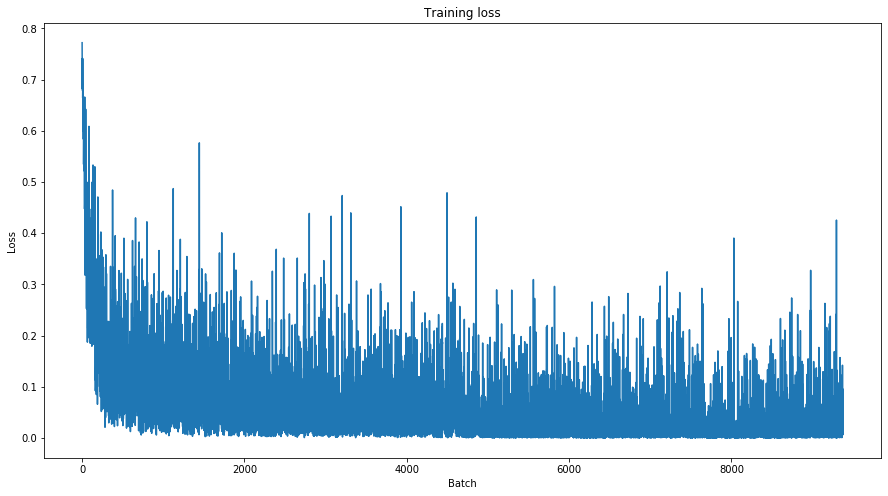

In [0]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(params=optimizer_grouped_parameters, lr=2e-5, weight_decay=0.01)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = NUM_EPOCHS

model.cuda()

# BERT training loop
for epoch in range(epochs):  
  print('Epoch {}/{}'.format(epoch+1, epochs))
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss, _ = model(input_ids = b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {:.4f}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = np.array(logits[0].cpu())
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {:.4f}\n".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Evaluate Model

In [0]:
def evaluate(model, test_inputs, test_masks, test_labels):
  # Convert all of our data into torch tensors, the required datatype for our model
  prediction_inputs = torch.tensor(test_inputs)
  prediction_masks = torch.tensor(test_masks)
  prediction_labels = torch.tensor(test_labels)

  # Select a batch size for training. 
  batch_size = BATCH_SIZE

  # Create an iterator of our data with torch DataLoader 
  prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  ## Prediction on test set
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  predictions , true_labels = [], []
  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits[0].cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
  matthews_set = []
  for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                  np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)
    
  # Flatten the predictions and true values for evaluation on the whole dataset
  flat_predictions = [item for sublist in predictions for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  flat_true_labels = [item for sublist in true_labels for item in sublist]

  scores = {
    'matthews_corrcoef_acc': matthews_corrcoef(flat_true_labels, flat_predictions),
    'precision': precision_score(flat_true_labels, flat_predictions),
    'recall': recall_score(flat_true_labels, flat_predictions),
    'f1_score': f1_score(flat_true_labels, flat_predictions),
    'accuracy': accuracy_score(flat_true_labels, flat_predictions)
  }

  return scores


In [0]:
semeval_file_path = DATASET_DIR_PATH + 'semeval-benchmark-v1.csv'
risk_file_path = DATASET_DIR_PATH + 'risk-models-benchmark-v1.csv'
nato_sfa_file_path = DATASET_DIR_PATH + 'nato-sfa-benchmark-v1.csv'
ce_me_file_path = DATASET_DIR_PATH + 'ce-me-benchmark-v1.csv'
ce_twitter_file_path = DATASET_DIR_PATH + 'twitter-causal-dataset.csv'

In [0]:
sem_eval_df = pd.read_csv(semeval_file_path, names=['cause', 'effect', 'label'], header=None)
sem_eval_df.head()

,cause,effect,label
0,dwarf,emission,causal
1,disease,blindness,causal
2,women,accident,causal
3,reading,rage,causal
4,snowstorm,losses,causal


In [0]:
risk_df = pd.read_csv(risk_file_path, names=['cause', 'effect', 'label'], header=None)
risk_df['cause'] = risk_df['cause'].apply(lambda x: re.sub('\s\[\d+\]$', '', x))  # remove '[n]' from the end
risk_df['effect'] = risk_df['effect'].apply(lambda x: re.sub('\s\[\d+\]$', '', x))  # remove '[n]' from the end
risk_df.head()

,cause,effect,label
0,increasing profits for our clients,increasing profits for our clients [13],causal
1,"increased speed efficiency, and lower cost","increased speed efficiency, and lower cost [11]",causal
2,increasing profits for our clients,increasing profits for our clients [13],causal
3,increasing profits for our clients,increasing profits for our clients [13],causal
4,increased importance of bundling products,increased importance of bundling products [16],causal


In [0]:

nato_sfa_df = pd.read_csv(nato_sfa_file_path, names=['cause', 'effect', 'label'], header=None)
nato_sfa_df.head()


,cause,effect,label
0,Increased global inequality,Migration,causal
1,Natural disasters,Unavailability of national military assets due...,causal
2,Increasingly connected human networks,An increasing need to understand human networks,causal
3,Fractured and/or polarized societies,Instability and civil war,causal
4,Fractured and/or polarized societies,Instability along NATO’s border causing large-...,causal


In [0]:
ce_me_df = pd.read_csv(ce_me_file_path, names=['cause', 'effect', 'label'], header=None)
ce_me_df.head()

,cause,effect,label
0,A strong dollar and a low oil price,profits of multinationals have dropped by 25%,causal
1,country increases imports,country decreasing balance of trade,causal
2,plunge in the value of local currency,country decreasing foreign reserves,causal
3,increase in national debt,decrease in real annual economic growth,causal
4,increase in the demand for a currency,rise in the exchange rate,causal


In [0]:
ce_twitter_df = pd.read_csv(ce_twitter_file_path)
ce_twitter_df['label'] = ce_twitter_df['label'].apply(lambda x: 'non_causal' if x == 'not-causal' else x)

ce_twitter_df.head()

,cause,effect,label
0,i ned to be front and centre,it’s al about me,non_causal
1,families truly suport girl-child,we can se that sky to is not the limit,causal
2,blinding youth with pelet guns was a #comonwea...,india would win a gold every hour,non_causal
3,they were so intolerant to an individuals thou...,they cant telecast #comonwealthgames2018 medal...,causal
4,you can't wait until then,you can watch it here:,causal


In [0]:

warnings.filterwarnings("ignore", category=RuntimeWarning) 

dataset_dfs = [sem_eval_df, nato_sfa_df, risk_df, ce_me_df, ce_twitter_df]
dataset_names = ['SemEval', 'NATO-SFA', 'Risk Models', 'CE Pairs', 'CE Tweets']
print('Dataset, accuracy, Precision, Recall, F1-score')

for dataset_df, dataset_name in zip(dataset_dfs, dataset_names):
  sentences = list(map(lambda x, y: x + ' may cause ' + y, dataset_df['cause'].tolist(), dataset_df['effect'].tolist()))
  labels = [1 if label=='causal' else 0 for label in dataset_df['label'].tolist()]

  input_ids = []
  # token_type_ids = []
  attention_masks = []

  for sentence in sentences:
    encoded_data = tokenizer.encode_plus(text=sentence, text_pair=None, max_length=MAX_SEQ_LEN, pad_to_max_length=True)
    input_ids.append(encoded_data['input_ids'])
    # token_type_ids.append(encoded_data['token_type_ids'])
    attention_masks.append(encoded_data['attention_mask'])

  scores = evaluate(model, input_ids, attention_masks, labels)
  print('{}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(dataset_name, scores['accuracy'], scores['precision'], scores['recall'], scores['f1_score']))

  # print('Classification accuracy of dataset {0} is {1:0.2%}'.format(dataset_name, scores['matthews_corrcoef_acc']))


Dataset, accuracy, Precision, Recall, F1-score
SemEval, 0.5197, 0.5100, 0.9977, 0.6750
NATO-SFA, 0.5000, 0.5000, 0.9492, 0.6550
Risk Models, 0.5000, 0.5000, 1.0000, 0.6667
CE Pairs, 0.5094, 0.5049, 0.9750, 0.6652
CE Tweets, 0.5120, 0.5069, 0.9542, 0.6621


### Visualization

In [0]:
def display_linechart_epochs(data, output_file):
    labels = {
        'epoch_1': '1',
        'epoch_2': '2',
        'epoch_3': '3',
        'epoch_4': '4',
    }
    # data = self.read_result_data()

    # if data is None:
    #     print("No data to plot")
    #     return

    x_axis = list(labels.values())
    # y_axis_str = [data[label]['scores'] for label in labels]
    y_axis_str = data 

    plt.clf()
    y_axis = []
    for score_item in y_axis_str:
        row = [float(num) for num in score_item]
        y_axis.append(row)
    y_axis_ar = np.array(y_axis)

    plt.plot(x_axis, y_axis_ar[:, 0], '-*', linewidth=1, alpha=0.9, label='Accuracy')
    plt.plot(x_axis, y_axis_ar[:, 1], '-D', linewidth=1, alpha=0.9, label='Precision')
    plt.plot(x_axis, y_axis_ar[:, 2], '->', linewidth=1, alpha=0.9, label='Recall')
    plt.plot(x_axis, y_axis_ar[:, 3], '-<', linewidth=1, alpha=0.9, label='F1-score')

    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.legend()

    # self.check_output_dir()
    plt.savefig(output_file)

data = [[0.5162,	0.5082,	0.9977,	0.6734], 
        [0.5197,	0.5100,	0.9977,	0.6750],
        [0.5168,	0.6124,	0.0913,	0.1590],
        [0.5503,	0.5267,	0.9908,	0.6878]]
output_file = 'sen_eval_epoch.pdf'
display_linechart_epochs(data, output_file)


data = [[0.4576,	0.4757,	0.8305,	0.6049],
        [0.4576,	0.4762,	0.8475,	0.6098],
        [0.5339,	0.5556,	0.3390,	0.4211],
        [0.4661,	0.4804,	0.8305,	0.6087]]
output_file = 'nato_sfa_epoch.pdf'
display_linechart_epochs(data, output_file)

data = [[0.5174,	0.5097,	0.9129,	0.6542],
        [0.5149,	0.5078,	0.9776,	0.6684],
        [0.4900,	0.4938,	0.7960,	0.6095],
        [0.5286,	0.5150,	0.9801,	0.6752]]
output_file = 'risk_models_epoch.pdf'
display_linechart_epochs(data, output_file)

data = [[0.5062,	0.5035,	0.9062,	0.6473],
        [0.5125,	0.5066,	0.9563,	0.6623],
        [0.5125,	0.5066,	0.9563,	0.6623],
        [0.5125,	0.5069,	0.9125,	0.6518]]
output_file = 'ce_pairs_epoch.pdf'
display_linechart_epochs(data, output_file)
